In [1]:
from keras.layers import Conv2D, Layer, Input, Conv2DTranspose, UpSampling2D, Cropping2D
from keras.optimizers import adam_v2
from keras.layers.advanced_activations import PReLU
from keras.models import Model
import keras
import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as K
import os 

사용자 정의 층 구현
---
keras.layers로부터 Layer 클래스를 상속받아 수정  
call 함수는 정방향 연산 진행
- Normalization_Layer  
- PowerConstraint  
- AWGN_Layer
     - snr값 단위 변환, 신호전력 계산
     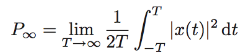

__init__에서는 층에 필요한 매개변수를 입력받음

In [3]:
class NormalizationNoise(Layer):
    def __init__(self, snr_db_def = 20, P_def=1, name='NormalizationNoise', **kwargs):
        self.snr_db = K.variable(snr_db_def, name='SNR_db')
        self.P = K.variable(P_def, name='Power')
        self.name = name 
        super(NormalizationNoise, self).__init__(**kwargs)

    def call(self, z_tilta): 
        with tf.name_scope('Normalization_Layer'):
            z_tilta = tf.dtypes.cast(z_tilta, dtype='complex128', name='ComplexCasting')+1j ###1j??  
            lst = z_tilta.get_shape().as_list() #행렬 차원을 리스트로 표현
            lst.pop(0) #0번째 요소

            #computing channel dimension 'k' as the channel bandwidth. #주파수 범위
            k = np.prod(lst, dtype='float32') #배열 원소들 간의 곱을 실수형으로

            #calculating conjugate transpose of z_tilta
            #전치행렬로 만들어서 복소수의 켤레 반환 ###0,2,1,3 모르겠음???
            z_conjugateT = tf.math.conj(tf.transpose(z_tilta, perm=[0,2,1,3], name='transpose'), name='z_ConjugateTrans')
            
            #Square root of k and P
            sqrt1 = tf.dtypes.cast(tf.math.sqrt(k*self.P, name='NormSqrt1'), dtype='complex128',name='ComplexCastingNorm')
            sqrt2 = tf.math.sqrt(z_conjugateT*z_tilta, name='NormSqrt2')#Square root of z_tilta* and z_tilta.
            div = tf.math.divide(z_tilta,sqrt2, name='NormDivision')
            
            #calculating channel input
            z = tf.math.multiply(sqrt1,div, name='Z')   
            
        with tf.name_scope('PowerConstraint'):     
            z_star = tf.math.conj(tf.transpose(z, perm=[0,2,1,3], name='transpose_Pwr'), name='z_star')
            prod = z_star*z 
            real_prod = tf.dtypes.cast(prod , dtype='float32', name='RealCastingPwr')
            pwr = tf.math.reduce_mean(real_prod)
            cmplx_pwr = tf.dtypes.cast(pwr, dtype='complex128', name='PowerComplexCasting')+1j
            pwr_constant = tf.constant(1.0, name ='PowerConstant')
            # Z: satisfies 1/kE[z*z] <= P, where P=1
            Z = tf.cond(pwr>pwr_constant, lambda: tf.math.divide(z,cmplx_pwr), lambda: z, name='Z_fixed')
             
        with tf.name_scope('AWGN_Layer'):     
            k=k.astype('float64')
            #Converting SNR from db scale to linear scale
            snr = 10**(self.snr_db/10.0)
            snr = tf.dtypes.cast(snr, dtype='float64', name='Float32_64Cast')
            
            ########### Calculating signal power ########### 
            #절대값
            abs_val = tf.math.abs(Z, name='abs_val')
            #각 값을 제곱하여 모두 더함
            summation = tf.math.reduce_sum(tf.math.square(abs_val, name='sq_awgn'), name='Summation')
            #k로 나누어서 신호전력을 구함
            sig_pwr = tf.math.divide(summation,k, name='Signal_Pwr')
            #SNR로 나누어 노이즈 전력을 구함
            noise_pwr = tf.math.divide(sig_pwr,snr, name='Noise_Pwr')
            #2로 나눈 값의 제곱근은 노이즈에 대한 시그마 값
            noise_sigma = tf.math.sqrt(noise_pwr/2, name='Noise_Sigma')

            #creating the complex normal distribution.
            z_img = tf.math.imag(Z, name = 'Z_imag')   
            z_real = tf.math.real(Z, name = 'Z_real')
            
            rand_dist = tf.random.normal(tf.shape(z_real), dtype=tf.dtypes.float64, name='RandNormalDist')
            #곱
            noise = tf.math.multiply(noise_sigma, rand_dist, name='Noise')
            
            #신호에 잡음 추가
            z_cap_Imag = tf.math.add(z_img, noise, name='z_cap_Imag') 
            z_cap_Imag = tf.dtypes.cast(z_cap_Imag, dtype='float32', name='NoisySignal_Imag')
            z_cap_Real = tf.math.add(z_real, noise, name='z_cap_Real') 
            z_cap_Real = tf.dtypes.cast(z_cap_Real, dtype='float32', name='NoisySignal_Real')
            
            return z_cap_Real  

체크포인트
---
on_epoch_begin 함수는 훈련 중 epoch가 시작될 때 호출됨  
epoch가 step의 배수이면(0, 50, 100....)이면, 폴더에 모델 저장  
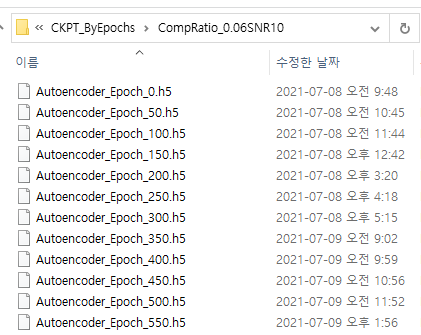

In [3]:
class ModelCheckponitsHandler(tf.keras.callbacks.Callback):
    def __init__(self, comp_ratio, snr_db, step, autoencoder):
        super(ModelCheckponitsHandler, self).__init__()
        self.comp_ratio = comp_ratio
        self.snr_db = snr_db
        self.step = step
        self.autoencoder = autoencoder

  def on_epoch_begin(self, epoch, logs=None):
    if epoch%self.step==0:
        os.makedirs('./CKPT_ByEpochs/CompRatio_'+str(self.comp_ratio)+'SNR'+str(self.snr_db), exist_ok=True)
        path = './CKPT_ByEpochs/CompRatio_'+str(self.comp_ratio)+'SNR'+str(self.snr_db)+'/Autoencoder_Epoch_'+str(epoch)+'.h5'
        self.autoencoder.save(path)
        print('\nModel Saved After {0} epochs.'.format(epoch))

필요한 필터 수 계산
---
지정된 압축률에 대해 마지막 컨볼루션 계층 및 첫 번째 트랜스포즈 컨볼루션 계층에 필요한 필터 수

In [2]:
def Calculate_filters(comp_ratio, F=5, n=3072):
    K = (comp_ratio*n)/F**2
    return int(K)

학습 모델
---

In [5]:
def TrainAutoEncoder(x_train, x_test, nb_epoch, comp_ratio, batch_size, c, snr, saver_step=50):
    ############################### Buliding Encoder ##############################
    input_images = Input(shape=(32,32,3))
    
    #P = Input(shape=(), name='Power')
    #snr_db = Input(shape=(), name='SNR_DB')
    #1st convolutional layer
    conv1 = Conv2D(filters=16, kernel_size=(5,5), strides=2, padding='valid', kernel_initializer='he_normal')(input_images)
    prelu1 = PReLU()(conv1)
    #2nd convolutional layer
    conv2 = Conv2D(filters=80, kernel_size=(5,5), strides=2, padding='valid', kernel_initializer='he_normal')(prelu1)
    prelu2 = PReLU()(conv2)
    #3rd convolutional layer
    conv3 = Conv2D(filters=50, kernel_size=(5,5), strides=1, padding='same', kernel_initializer='he_normal')(prelu2)
    prelu3 = PReLU()(conv3)
    #4th convolutional layer
    conv4 = Conv2D(filters=40, kernel_size=(5,5), strides=1, padding='same', kernel_initializer='he_normal')(prelu3)
    prelu4 = PReLU()(conv4)
    #5th convolutional layer
    conv5 = Conv2D(filters=c, kernel_size=(5,5), strides=1, padding='same', kernel_initializer='he_normal')(prelu4)
    encoder = PReLU()(conv5)
    
    #사용자 정의 층
    real_prod   = NormalizationNoise()(encoder)
    
    ############################### Building Decoder ##############################
    #1st Deconvolutional layer
    decoder = Conv2DTranspose(filters=40, kernel_size=(5,5), strides=1, padding='same', kernel_initializer='he_normal')(real_prod )
    decoder = PReLU()(decoder)
    #2nd Deconvolutional layer
    decoder = Conv2DTranspose(filters=50, kernel_size=(5,5), strides=1, padding='same', kernel_initializer='he_normal')(decoder)
    decoder = PReLU()(decoder)
    #3rd Deconvolutional layer
    decoder = Conv2DTranspose(filters=80, kernel_size=(5,5), strides=1, padding='same', kernel_initializer='he_normal')(decoder)
    decoder = PReLU()(decoder)
    #4th Deconvolutional layer
    decoder = Conv2DTranspose(filters=16, kernel_size=(5,5), strides=2, padding='valid', kernel_initializer='he_normal')(decoder)
    decoder = PReLU()(decoder)
    #decoder_up = UpSampling2D((2,2))(decoder)
    #5th Deconvolutional layer
    decoder = Conv2DTranspose(filters=3, kernel_size=(5,5), strides=2, padding='valid', kernel_initializer='he_normal', activation ='sigmoid')(decoder)
    #decoder = PReLU()(decoder)
    decoder_up = UpSampling2D((2,2))(decoder)
    decoder = Cropping2D(cropping=((13,13),(13,13)))(decoder_up)
    
    ############################### Buliding Models ###############################
    autoencoder = Model(input_images, decoder)
    
    K.set_value(autoencoder.get_layer('normalization_noise_1').snr_db, snr)
    autoencoder.compile(optimizer= Adam(learning_rate=0.0001), loss='mse', metrics=['accuracy'])
    autoencoder.summary()
    print('\t-----------------------------------------------------------------')
    print('\t|\t\t\t\t\t\t\t\t|')
    print('\t|\t\t\t\t\t\t\t\t|')
    print('\t| Training Parameters: Filter Size: {0}, Compression ratio: {1} |'.format(c, comp_ratio))
    print('\t|\t\t\t  SNR: {0} dB\t\t\t\t|'.format(snr))
    print('\t|\t\t\t\t\t\t\t\t|')
    print('\t|\t\t\t\t\t\t\t\t|')
    print('\t-----------------------------------------------------------------')
    
    tb = keras.callbacks.tensorboard_v1.TensorBoard(log_dir='./Tensorboard/CompRatio{0}_SNR{1}'.format(str(comp_ratio), str(snr)))
    os.makedirs('./checkpoints/CompRatio{0}_SNR{1}'.format(str(comp_ratio), str(snr)), exist_ok=True)
    checkpoint = keras.callbacks.callbacks.ModelCheckpoint(filepath='./checkpoints/CompRatio{0}_SNR{1}'.format(str(comp_ratio), str(snr))+'/Autoencoder.h5', monitor='val_loss', save_best_only=True)
    ckpt = ModelCheckponitsHandler(comp_ratio, snr, autoencoder, step=saver_step)
    history = autoencoder.fit(x=x_train, y=x_train, batch_size=batch_size, epochs=nb_epoch,  callbacks=[tb, checkpoint, ckpt], validation_data=(x_test,x_test))
    return history